In [53]:
import datetime as dt
import itertools
from pathlib import Path

import cartopy.crs as ccrs
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import seaborn as sns
import xarray as xr

from remake import load_remake

from mcs_prime import McsTracks, McsTrack, PATHS


In [3]:
rmk = load_remake('../../remakefiles/plotting.py').finalize()

=> plotting <=


In [5]:
t1, t2 = rmk.PlotCorrelationsMcsLocalEnvPrecursorMeanValue.tasks

In [6]:
t1

4ac52a6d55 PlotCorrelationsMcsLocalEnvPrecursorMeanValue(year=2020, filter='land-sea')

In [7]:
t1.inputs

{'mcs_local_env_2020_1': PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/01/lifecycle_mcs_local_env_2020_01.nc'),
 'mcs_local_env_2020_2': PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/02/lifecycle_mcs_local_env_2020_02.nc'),
 'mcs_local_env_2020_3': PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/03/lifecycle_mcs_local_env_2020_03.nc'),
 'mcs_local_env_2020_4': PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/04/lifecycle_mcs_local_env_2020_04.nc'),
 'mcs_local_env_2020_5': PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/05/lifecycle_mcs_local_env_2020_05.nc'),
 'mcs_local_env_2020_6': PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/06/lifecycle_mcs_local_env_2020_06.nc'),
 'mcs_local_env_2020_7': PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_e

In [8]:
ds = xr.open_mfdataset([p for k, p in t1.inputs.items() if k.startswith('mcs_local_env')])

In [9]:
ds

<xarray.Dataset>
Dimensions:                                             (tracks: 32138,
                                                         radius: 5, times: 424,
                                                         percentile: 5)
Coordinates:
  * tracks                                              (tracks) int64 0 ... ...
  * radius                                              (radius) int64 1 ... ...
  * times                                               (times) int64 -24 ......
  * percentile                                          (percentile) int64 10...
Data variables: (12/26)
    mean_cape                                           (tracks, radius, times) float64 dask.array<chunksize=(2406, 5, 424), meta=np.ndarray>
    percentile_cape                                     (tracks, radius, percentile, times) float64 dask.array<chunksize=(2406, 5, 5, 424), meta=np.ndarray>
    mean_tcwv                                           (tracks, radius, times) float64 dask.array<chunksize=(2406, 5, 424), meta=np.ndarray>
    percentile_tcwv                                     (tracks, radius, percentile, times) float64 dask.array<chunksize=(2406, 5, 5, 424), meta=np.ndarray>
    mean_cin                                            (tracks, radius, times) float64 dask.array<chunksize=(2406, 5, 424), meta=np.ndarray>
    percentile_cin                                      (tracks, radius, percentile, times) float64 dask.array<chunksize=(2406, 5, 5, 424), meta=np.ndarray>
    ...                                                  ...
    mean_theta_e_mid                                    (tracks, radius, times) float64 dask.array<chunksize=(2406, 5, 424), meta=np.ndarray>
    percentile_theta_e_mid                              (tracks, radius, percentile, times) float64 dask.array<chunksize=(2406, 5, 5, 424), meta=np.ndarray>
    mean_delta_3h_cape                                  (tracks, radius, times) float64 dask.array<chunksize=(2406, 5, 424), meta=np.ndarray>
    percentile_delta_3h_cape                            (tracks, radius, percentile, times) float64 dask.array<chunksize=(2406, 5, 5, 424), meta=np.ndarray>
    mean_delta_3h_tcwv                                  (tracks, radius, times) float64 dask.array<chunksize=(2406, 5, 424), meta=np.ndarray>
    percentile_delta_3h_tcwv                            (tracks, radius, percentile, times) float64 dask.array<chunksize=(2406, 5, 5, 424), meta=np.ndarray>
Attributes:
    created by:           /home/users/mmuetz/projects/mcs_prime/ctrl/remakefi...
    calling file source:  """Remakefile to calculate local environments based...
    project repository:   https://github.com/markmuetz/MCS_PRIME
    remake version:       ['0', '6', '3', '0', 'beta']
    remake repository:    https://github.com/markmuetz/remake
    task:                 cb87fdf11a LifecycleMcsLocalEnv(year=2020, month=1)
    task doc:             Capture the env at various radii over the lifecycle...
    created on:           2023-11-16 21:14:59.739292
    nodename:             host638.jc.rl.ac.uk
    hostname:             jasmin
    output path:          /gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_outpu...
    contact:              mark.muetzelfeldt@reading.ac.uk

In [17]:
mean_keys = [k for k in ds.data_vars.keys() if k.startswith('mean_')]

In [18]:
data_dict = {k: ds[k].sel(radius=200, times=0).values for k in mean_keys}


In [23]:
data_dict['mean_MFC'] = data_dict.pop('mean_vertically_integrated_moisture_flux_div')
df = pd.DataFrame(data_dict)

In [24]:
df

mean_cape  mean_tcwv   mean_cin  mean_shear_0  mean_shear_1  \
0       214.934755  52.122157        NaN     16.228013      8.086964   
1       125.416014  32.003502        NaN     10.296268      5.509478   
2        28.352805  44.087772        NaN     15.471921      7.577292   
3       450.362983  64.204681  40.891294      3.135435      1.696684   
4       834.227265  59.358972  40.599314      7.396987      1.979982   
...            ...        ...        ...           ...           ...   
32133   507.584371  63.113382  12.935850      4.140102      4.332973   
32134   233.830593  34.350406        NaN      3.104799      2.104866   
32135     3.533215  33.384589        NaN     18.141381     10.379812   
32136  1227.497288  56.157951        NaN      3.617192      6.947114   
32137   564.545482  44.258108        NaN      8.451684      9.430957   

       mean_shear_2  mean_shear_3  mean_RHlow  mean_RHmid  mean_theta_e_mid  \
0          5.906509     24.786453    0.915374    0.758252        339.872273   
1         11.203067     23.360493    0.865386    0.806495        316.615783   
2         14.703172     22.185569    0.800298    0.654032        333.869488   
3          3.087365      4.328462    0.906508    0.862347        344.845938   
4          6.287691      7.687501    0.894456    0.570485        346.965773   
...             ...           ...         ...         ...               ...   
32133      4.482668      8.881352    0.928144    0.891912        344.599691   
32134      5.271835      4.999642    0.694892    0.563763        341.402435   
32135      9.558769     28.103377    0.787881    0.816434        317.091116   
32136      4.092929      8.052283    0.880559    0.791134        343.829664   
32137      9.849460     24.917473    0.930456    0.761486        343.184422   

       mean_delta_3h_cape  mean_delta_3h_tcwv  mean_MFC  
0              -45.702852           -0.828520 -0.000587  
1               40.359969            2.964504 -0.000222  
2               10.292924            2.256839 -0.000002  
3               75.075504            2.469141 -0.000418  
4             -130.426790           -1.520011  0.000033  
...                   ...                 ...       ...  
32133          130.564479            0.041838 -0.000782  
32134           61.253622            1.608319 -0.000242  
32135            1.883747            7.037831 -0.000677  
32136          225.059206           -1.245686 -0.000395  
32137          -42.761185            1.101717 -0.000408  

[32138 rows x 13 columns]

In [39]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

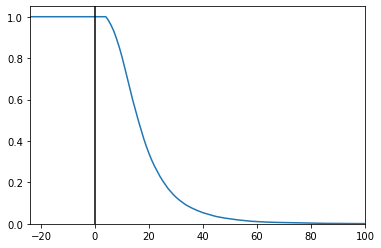

In [37]:
plt.plot(range(-24, 400), (len(ds.tracks) - np.isnan(ds.mean_cape.sel(radius=200).values).sum(axis=0)) / len(ds.tracks))
plt.xlim(-24, 100)
plt.ylim(0, 1.05)
plt.axvline(0, color='k')

In [50]:
def corr_at_time(ds, time=0, radius=200):
    data_dict = {k: ds[k].sel(radius=radius, times=time).values for k in mean_keys}
    data_dict['mean_MFC'] = data_dict.pop('mean_vertically_integrated_moisture_flux_div')
    df = pd.DataFrame(data_dict)
    corr = df.corr()
    return corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

In [44]:
corr_at_time(ds)

In [45]:
corr_at_time(ds, -10)

In [46]:
corr_at_time(ds, 10)

In [51]:
corr_at_time(ds, 0, 100)

In [49]:
corr_at_time(ds, 0, 200)

In [52]:
corr_at_time(ds, 0, 500)

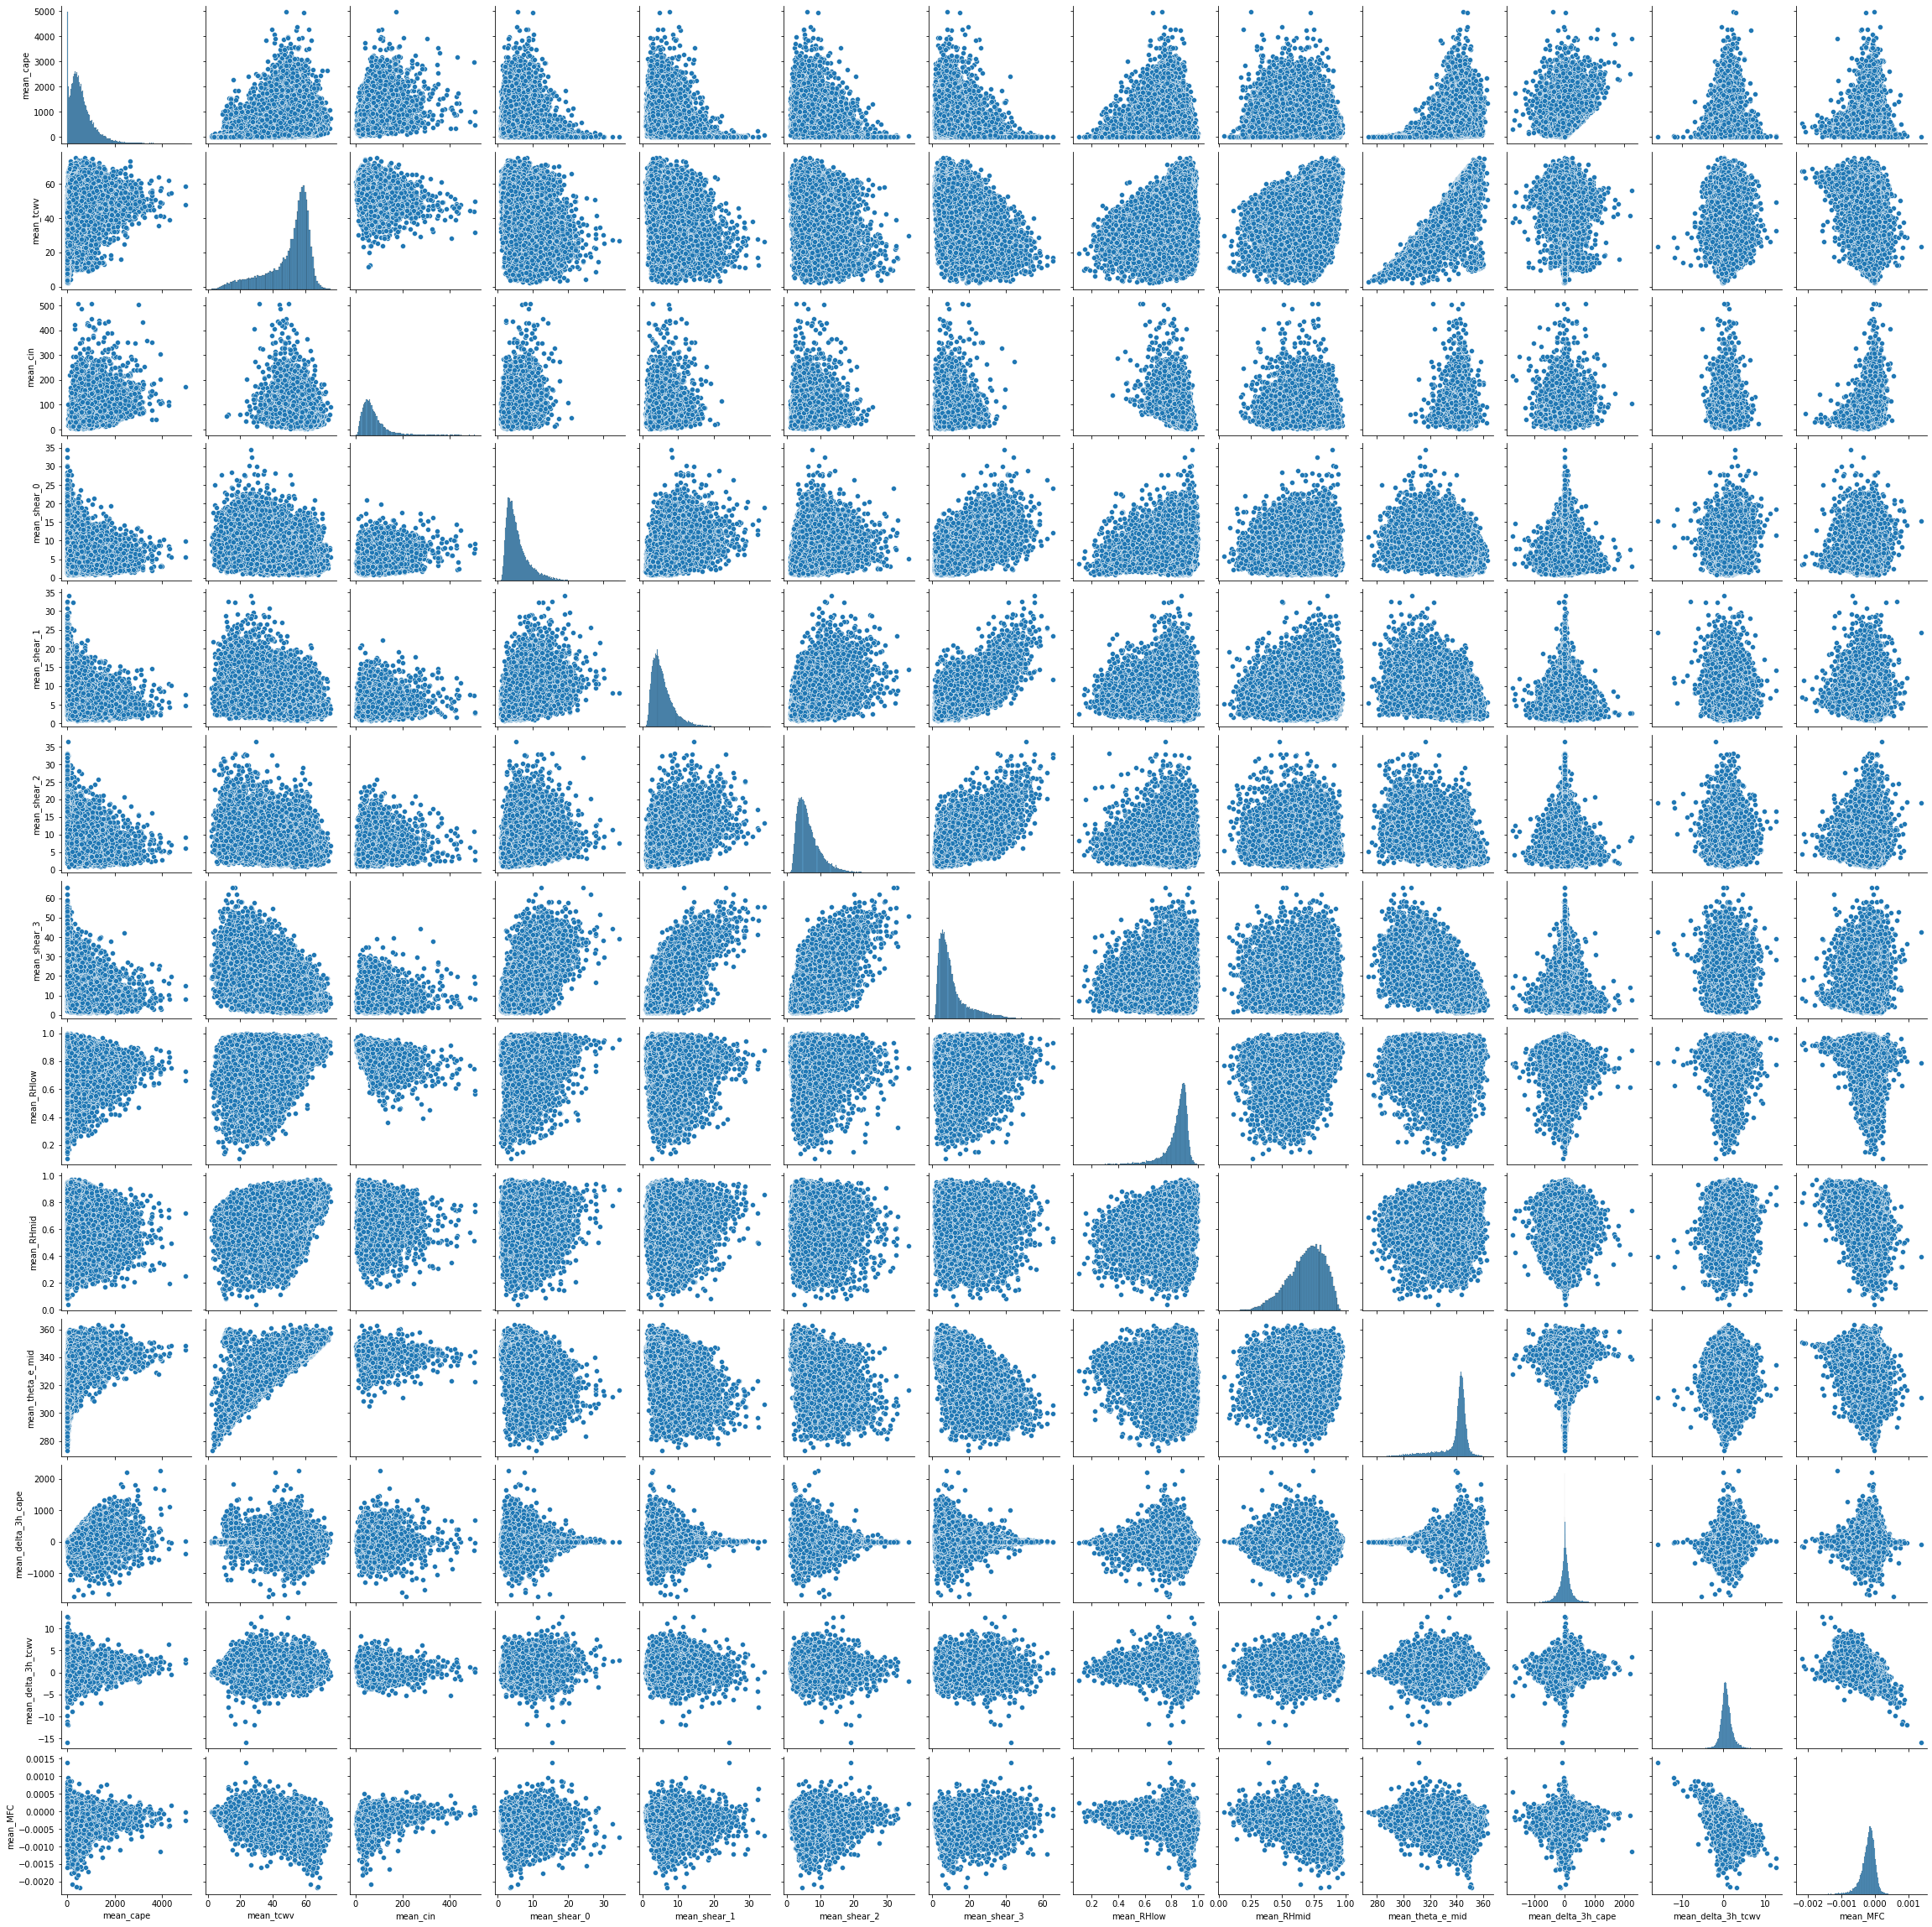

In [55]:
sns.pairplot(df)

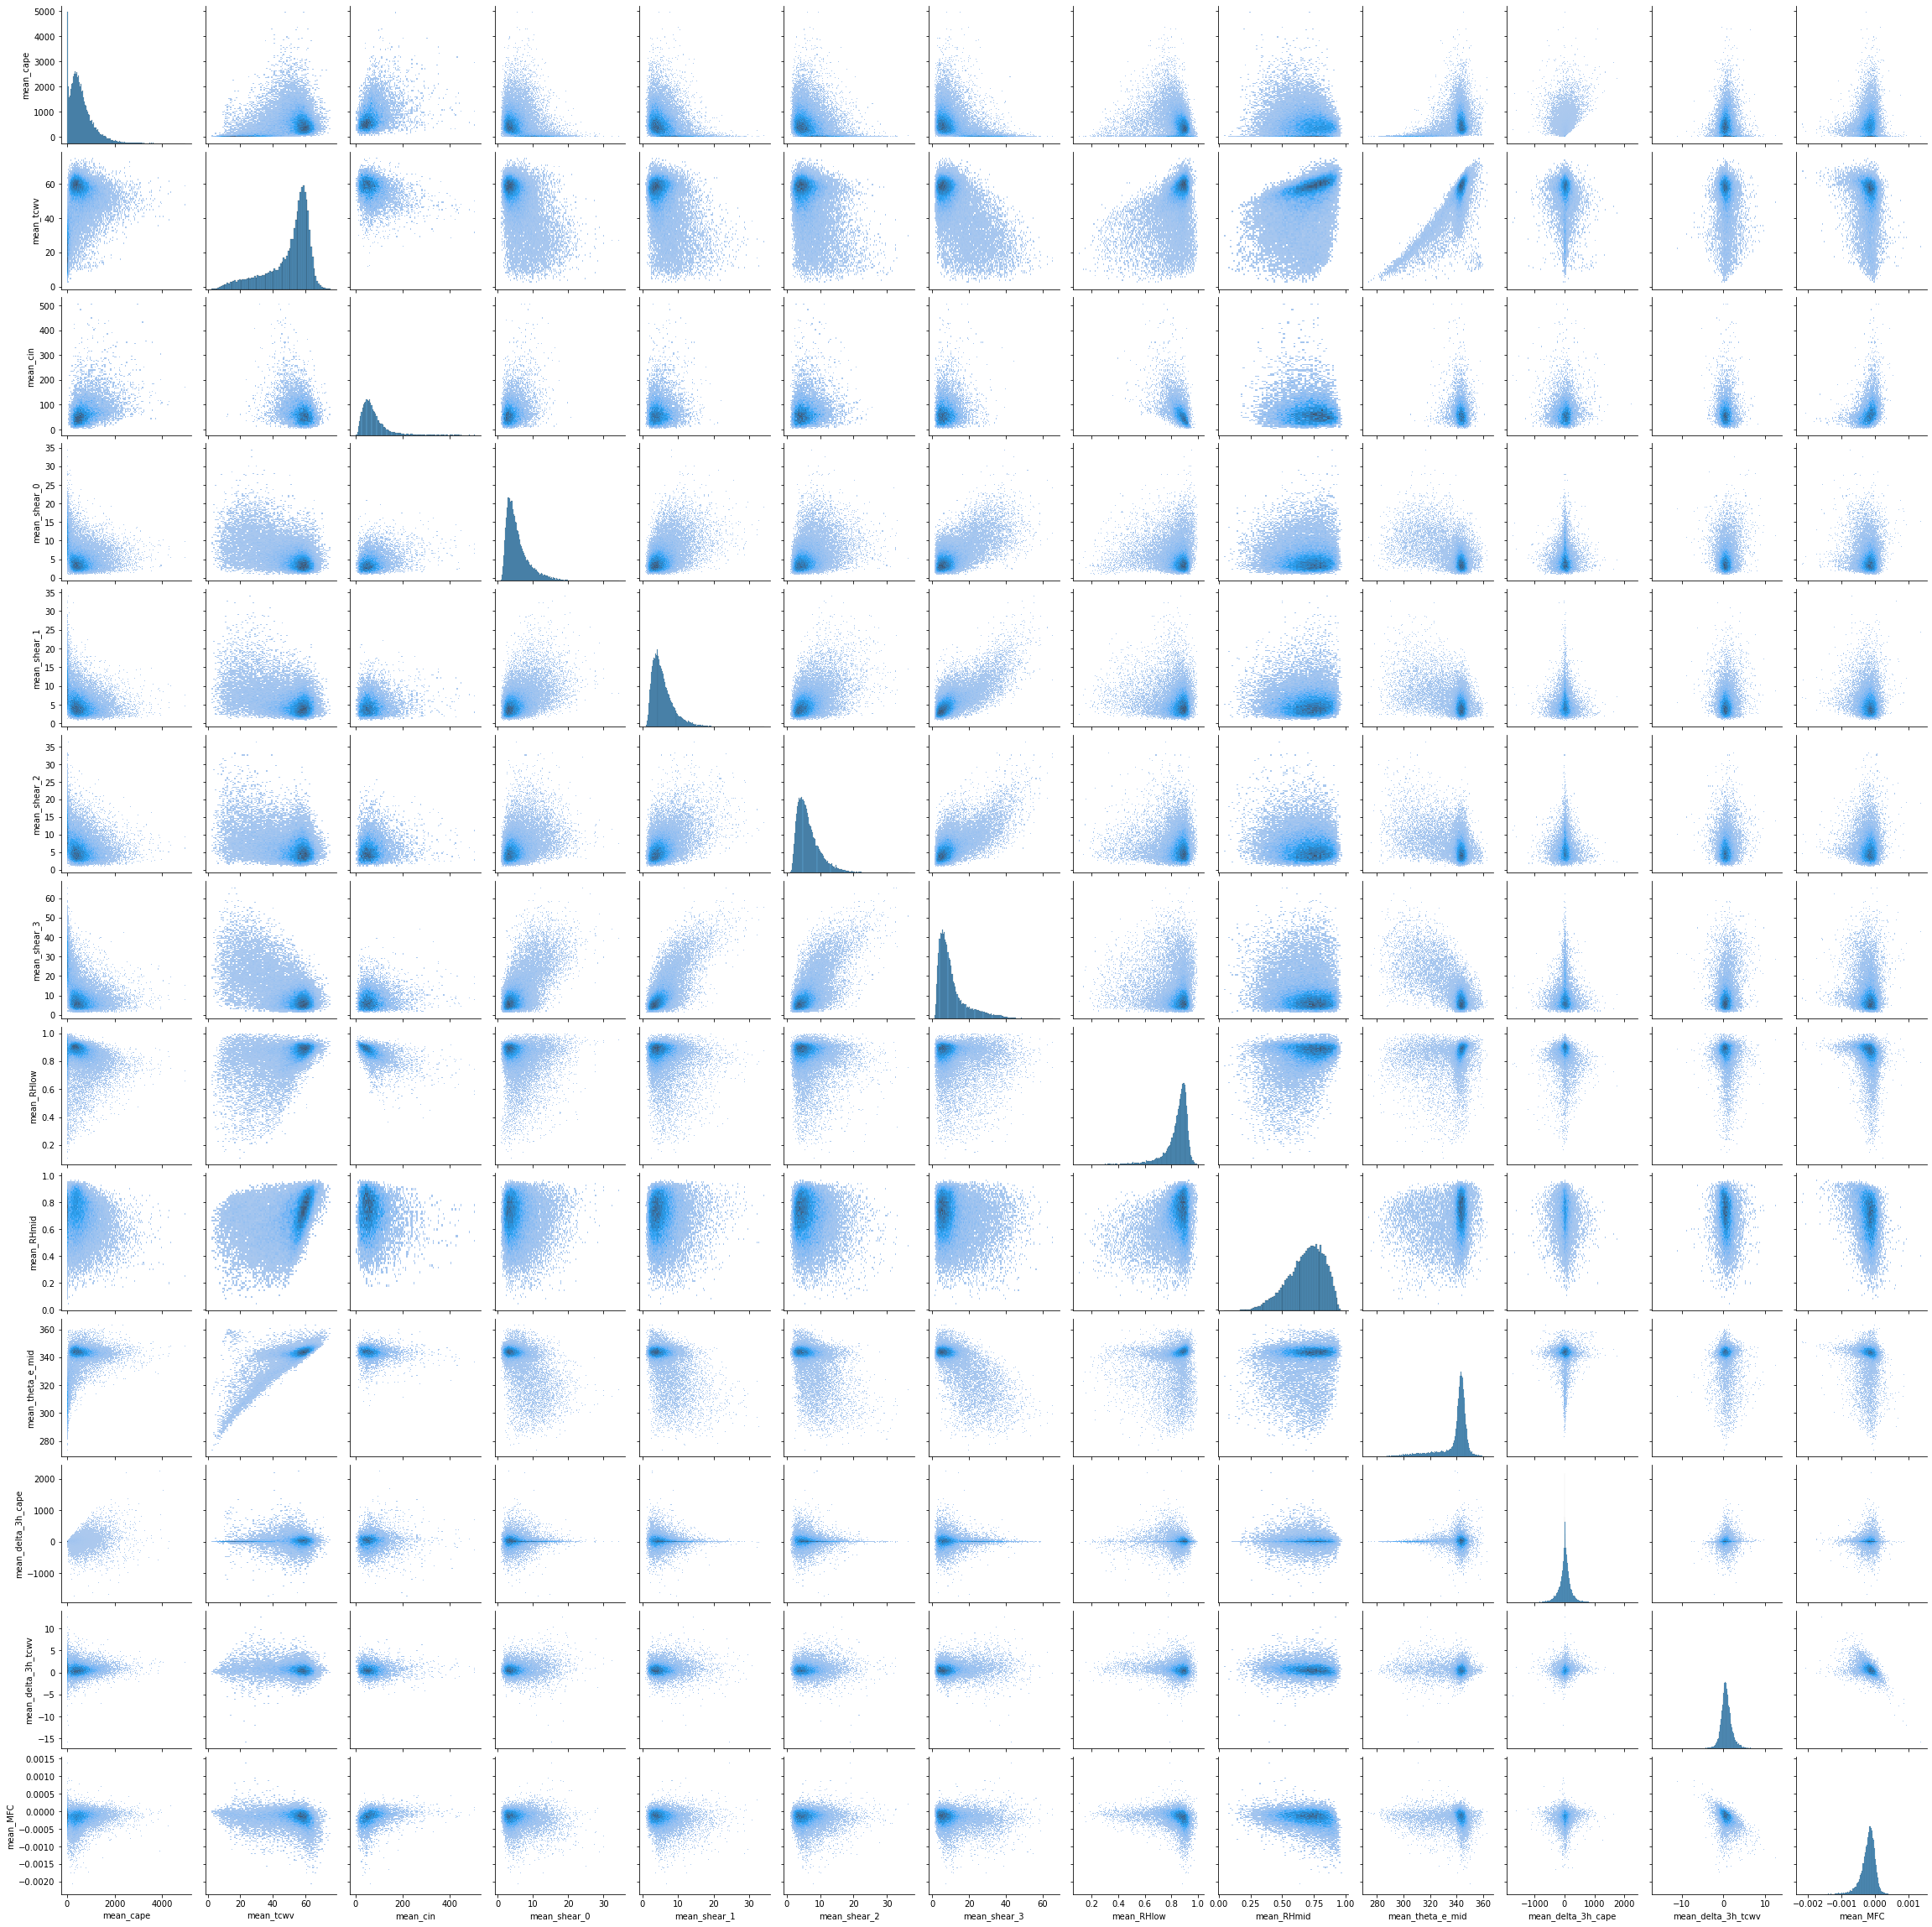

In [56]:
sns.pairplot(df, kind='hist')